In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, Union
import warnings
import io
import os
from pathlib import Path
import json

COLAB_AVAILABLE = False

warnings.filterwarnings('ignore')

class TTestAnalyzer:
    def __init__(self, alpha: float = 0.05):
        self.alpha = alpha
        self.results = {}
        self.uploaded_data = None

    def upload_file(self, method: str = 'upload') -> pd.DataFrame:
        """
        Métodos soportados en VS Code:
          - 'upload'  -> abre un selector de archivos del sistema (recomendado)
          - 'local'   -> pide por consola la ruta completa (C:/... o /home/...)
          - 'url'     -> pide la URL (CSV/Excel/JSON)
        """
        # 1) Selección por diálogo (OS file picker)
        if method in ('upload', 'dialog'):
            try:
                from tkinter import Tk, filedialog
                root = Tk()
                root.withdraw()
                filetypes = [
                    ('CSV', '*.csv'),
                    ('Excel', '*.xlsx *.xls'),
                    ('JSON', '*.json'),
                    ('Texto', '*.txt *.tsv'),
                    ('Todos', '*.*'),
                ]
                file_path = filedialog.askopenfilename(
                    title='Selecciona un archivo de datos', filetypes=filetypes
                )
                root.update()
                root.destroy()
                if not file_path:
                    raise ValueError("No seleccionaste ningún archivo.")
                return self._load_from_path(file_path)
            except Exception as e:
                print(f"ℹ️ No se pudo abrir el diálogo ({e}).")
                file_path = input("📝 Ingrese la ruta completa del archivo: ").strip()
                return self._load_from_path(file_path)

        # 2) Ruta local por consola
        elif method == 'local':
            file_path = input("📝 Ingrese la ruta completa del archivo: ").strip()
            return self._load_from_path(file_path)

        # 3) Desde URL directa
        elif method == 'url':
            url = input("🌐 Ingrese la URL del archivo (CSV/Excel/JSON): ").strip()
            try:
                if url.endswith('.csv'):
                    return pd.read_csv(url)
                elif url.endswith(('.xlsx', '.xls')):
                    return pd.read_excel(url)
                elif url.endswith('.json'):
                    return pd.read_json(url)
                else:
                    # Intento genérico (muchas URLs CSV no traen extensión)
                    return pd.read_csv(url)
            except Exception as e:
                raise ValueError(f"Error cargando desde URL: {e}")

        else:
            raise ValueError("Método no soportado. Usa 'upload', 'local' o 'url'.")

    def _process_file(self, filename: str, file_content: bytes) -> pd.DataFrame:
        file_ext = Path(filename).suffix.lower()

        try:
            if file_ext == '.csv':
                for encoding in ['utf-8', 'latin-1', 'cp1252']:
                    try:
                        content_str = file_content.decode(encoding)
                        for sep in [',', ';', '\t', '|']:
                            try:
                                df = pd.read_csv(io.StringIO(content_str), sep=sep)
                                if df.shape[1] > 1:
                                    print(f"✅ Archivo CSV cargado (encoding: {encoding}, separador: '{sep}')")
                                    return df
                            except:
                                continue

                        df = pd.read_csv(io.StringIO(content_str))
                        print(f"✅ Archivo CSV cargado (encoding: {encoding})")
                        return df

                    except UnicodeDecodeError:
                        continue

                raise ValueError("No se pudo decodificar el archivo CSV")

            elif file_ext in ['.xlsx', '.xls']:
                df = pd.read_excel(io.BytesIO(file_content))
                print("✅ Archivo Excel cargado")
                return df

            elif file_ext == '.json':
                content_str = file_content.decode('utf-8')
                data = json.loads(content_str)
                df = pd.json_normalize(data) if isinstance(data, list) else pd.DataFrame(data)
                print("✅ Archivo JSON cargado")
                return df

            elif file_ext in ['.txt', '.tsv']:
                content_str = file_content.decode('utf-8')
                df = pd.read_csv(io.StringIO(content_str), sep='\t')
                print("✅ Archivo de texto delimitado cargado")
                return df

            else:
                raise ValueError(f"Tipo de archivo no soportado: {file_ext}")

        except Exception as e:
            raise ValueError(f"Error procesando archivo {filename}: {e}")

    def _load_from_path(self, file_path: str) -> pd.DataFrame:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

        file_ext = Path(file_path).suffix.lower()

        try:
            if file_ext == '.csv':
                df = pd.read_csv(file_path, encoding='utf-8')
                print("✅ Archivo CSV cargado desde ruta local")
                return df

            elif file_ext in ['.xlsx', '.xls']:
                df = pd.read_excel(file_path)
                print("✅ Archivo Excel cargado desde ruta local")
                return df

            elif file_ext == '.json':
                df = pd.read_json(file_path)
                print("✅ Archivo JSON cargado desde ruta local")
                return df

            elif file_ext in ['.txt', '.tsv']:
                df = pd.read_csv(file_path, sep='\t')
                print("✅ Archivo de texto cargado desde ruta local")
                return df

            else:
                raise ValueError(f"Tipo de archivo no soportado: {file_ext}")

        except Exception as e:
            raise ValueError(f"Error cargando archivo {file_path}: {e}")

    def validate_data(self, df: pd.DataFrame, show_details: bool = True) -> dict:
        report = {
            'shape': df.shape,
            'columns': list(df.columns),
            'dtypes': df.dtypes.to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'duplicated_rows': df.duplicated().sum(),
            'numeric_columns': [],
            'non_numeric_columns': [],
            'problems': [],
            'recommendations': []
        }

        if show_details:
            print("🔍 VALIDACIÓN DE DATOS")
            print("=" * 40)
            print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
            print(f"📝 Columnas: {', '.join(df.columns)}")

        # Clasificar columnas por tipo
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                report['numeric_columns'].append(col)
            else:
                report['non_numeric_columns'].append(col)

        if show_details:
            print(f"🔢 Columnas numéricas: {len(report['numeric_columns'])}")
            print(f"📝 Columnas no numéricas: {len(report['non_numeric_columns'])}")

        # Verificar valores faltantes REALES
        missing_total = df.isnull().sum().sum()
        if missing_total > 0:
            missing_by_column = df.isnull().sum()
            real_missing_problems = False

            if df.shape[1] == 2:
                col1, col2 = df.columns
                missing1 = missing_by_column[col1]
                missing2 = missing_by_column[col2]

                # Verificar patrón de muestras independientes (faltantes al final)
                if missing1 > 0:
                    last_valid_idx1 = df[col1].last_valid_index()
                    if last_valid_idx1 is not None:
                        after_last_valid = df.loc[last_valid_idx1+1:, col1]
                        missing_at_end1 = len(after_last_valid) == 0 or after_last_valid.isnull().all()
                    else:
                        missing_at_end1 = False
                else:
                    missing_at_end1 = True

                if missing2 > 0:
                    last_valid_idx2 = df[col2].last_valid_index()
                    if last_valid_idx2 is not None:
                        after_last_valid = df.loc[last_valid_idx2+1:, col2]
                        missing_at_end2 = len(after_last_valid) == 0 or after_last_valid.isnull().all()
                    else:
                        missing_at_end2 = False
                else:
                    missing_at_end2 = True

                real_missing_problems = not (missing_at_end1 and missing_at_end2)

                if not real_missing_problems and show_details:
                    valid1 = len(df) - missing1
                    valid2 = len(df) - missing2
                    print(f"\n📊 Detectadas muestras independientes:")
                    print(f"   {col1}: {valid1} observaciones")
                    print(f"   {col2}: {valid2} observaciones")
                    if valid1 != valid2:
                        print("   ✅ Tamaños diferentes son normales para muestras independientes")
                    else:
                        print("   ℹ️  Mismo tamaño: pueden ser independientes o pareadas")
            else:
                real_missing_problems = True

            if real_missing_problems:
                report['problems'].append(f"Valores faltantes problemáticos: {missing_total} total")
                report['recommendations'].append("Revisar patrones de valores faltantes - pueden indicar problemas de calidad")

                if show_details:
                    print("\n⚠️  VALORES FALTANTES PROBLEMÁTICOS:")
                    for col, missing in report['missing_values'].items():
                        if missing > 0:
                            pct = (missing / len(df)) * 100
                            print(f"   {col}: {missing} ({pct:.1f}%)")
                            null_positions = df[df[col].isnull()].index.tolist()[:5]
                            print(f"      Posiciones de algunos faltantes: {null_positions}")

        # Verificar filas duplicadas
        if report['duplicated_rows'] > 0:
            report['problems'].append(f"Filas duplicadas: {report['duplicated_rows']}")
            report['recommendations'].append("Revisar y posiblemente eliminar filas duplicadas")
            if show_details:
                print(f"\n⚠️  Filas duplicadas: {report['duplicated_rows']}")

        # Verificar columnas no numéricas
        if report['non_numeric_columns']:
            for col in report['non_numeric_columns']:
                unique_vals = df[col].nunique()
                sample_vals = df[col].dropna().unique()[:5]
                report['problems'].append(f"Columna no numérica: {col}")

                if show_details:
                    print(f"\n⚠️  Columna no numérica '{col}':")
                    print(f"   Valores únicos: {unique_vals}")
                    print(f"   Muestra: {list(sample_vals)}")

                try:
                    numeric_col = pd.to_numeric(df[col], errors='coerce')
                    if not numeric_col.isnull().all():
                        conversion_success = (numeric_col.notnull().sum() / len(df)) > 0.8
                        if conversion_success:
                            report['recommendations'].append(f"Columna '{col}' puede convertirse a numérica")
                            if show_details:
                                print(f"   ✅ Puede convertirse a numérica ({conversion_success:.1%} éxito)")
                except:
                    pass

        # Verificar distribuciones extremas
        for col in report['numeric_columns']:
            col_data = df[col].dropna()
            if len(col_data) > 0:
                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1
                outliers = ((col_data < (Q1 - 1.5 * IQR)) | (col_data > (Q3 + 1.5 * IQR))).sum()

                if outliers > len(col_data) * 0.1:
                    report['problems'].append(f"Columna '{col}': {outliers} outliers potenciales")
                    report['recommendations'].append(f"Revisar outliers en columna '{col}'")

                if col_data.std() < 1e-10:
                    report['problems'].append(f"Columna '{col}': varianza muy baja o constante")
                    report['recommendations'].append(f"Columna '{col}' puede ser constante - verificar utilidad")

        # Resumen final
        if show_details:
            print(f"\n📋 RESUMEN:")
            print(f"   ✅ Columnas numéricas listas: {len(report['numeric_columns'])}")
            print(f"   ⚠️  Problemas encontrados: {len(report['problems'])}")
            print(f"   💡 Recomendaciones: {len(report['recommendations'])}")

            if report['problems']:
                print("\n🔧 PROBLEMAS DETECTADOS:")
                for i, problem in enumerate(report['problems'], 1):
                    print(f"   {i}. {problem}")

            if report['recommendations']:
                print("\n💡 RECOMENDACIONES:")
                for i, rec in enumerate(report['recommendations'], 1):
                    print(f"   {i}. {rec}")

        return report

    def clean_data(self, df: pd.DataFrame, validation_report: dict) -> pd.DataFrame:
        df_clean = df.copy()
        cleaning_actions = []

        print("\n🧹 LIMPIEZA AUTOMÁTICA DE DATOS")
        print("=" * 40)

        # Convertir columnas no numéricas si es posible
        for col in validation_report['non_numeric_columns']:
            try:
                numeric_col = pd.to_numeric(df_clean[col], errors='coerce')
                if (numeric_col.notnull().sum() / len(df_clean)) > 0.8:
                    df_clean[col] = numeric_col
                    cleaning_actions.append(f"Convertida '{col}' a numérica")
                    print(f"✅ Columna '{col}' convertida a numérica")
            except:
                pass

        # Eliminar filas con todos los valores faltantes
        initial_rows = len(df_clean)
        df_clean = df_clean.dropna(how='all')
        if len(df_clean) < initial_rows:
            removed = initial_rows - len(df_clean)
            cleaning_actions.append(f"Eliminadas {removed} filas completamente vacías")
            print(f"🗑️  Eliminadas {removed} filas completamente vacías")

        # Eliminar duplicados
        if validation_report['duplicated_rows'] > 0:
            df_clean = df_clean.drop_duplicates()
            cleaning_actions.append(f"Eliminadas {validation_report['duplicated_rows']} filas duplicadas")
            print(f"🗑️  Eliminadas {validation_report['duplicated_rows']} filas duplicadas")

        # Filtrar solo columnas numéricas para análisis
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            raise ValueError("No hay columnas numéricas para análisis después de la limpieza")

        df_final = df_clean[numeric_cols].copy()

        # Para muestras independientes, NO eliminar filas con valores faltantes
        if df_final.shape[1] >= 2:
            print("📊 Manteniendo estructura para muestras independientes")
            print("   (Los valores faltantes por diferencia de tamaño son normales)")
        else:
            initial_rows = len(df_final)
            df_final = df_final.dropna()
            if len(df_final) < initial_rows:
                removed = initial_rows - len(df_final)
                cleaning_actions.append(f"Eliminadas {removed} filas con valores faltantes")
                print(f"🗑️  Eliminadas {removed} filas con valores faltantes")

        print(f"\n📊 Datos finales: {df_final.shape[0]} filas × {df_final.shape[1]} columnas")
        print(f"📝 Columnas disponibles: {', '.join(df_final.columns)}")

        if len(df_final) > 0:
            print(f"\n📋 Muestra de datos limpios:")
            print(df_final.head())

            print(f"\n📈 Estadísticas básicas:")
            print(df_final.describe())

        return df_final

    def load_and_validate_file(self, method: str = 'upload') -> pd.DataFrame:
        print("🎯 CARGA Y VALIDACIÓN DE ARCHIVO")
        print("=" * 50)

        df_raw = self.upload_file(method)
        print(f"✅ Archivo cargado exitosamente")

        print(f"\n👀 Vista previa de los datos:")
        print(df_raw.head())

        validation_report = self.validate_data(df_raw)

        if validation_report['problems']:
            print(f"\n❓ Se encontraron {len(validation_report['problems'])} problemas.")
            clean_auto = input("¿Desea aplicar limpieza automática? (s/n): ").lower().startswith('s')

            if clean_auto:
                df_clean = self.clean_data(df_raw, validation_report)
                self.uploaded_data = df_clean
                return df_clean
            else:
                print("⚠️  Continuando con datos sin limpiar. Algunos análisis pueden fallar.")
                self.uploaded_data = df_raw
                return df_raw
        else:
            print("✅ No se encontraron problemas significativos en los datos")
            self.uploaded_data = df_raw
            return df_raw

    def analyze_from_file(self, method: str = 'upload', mu0: Optional[float] = None,
                          column_names: Optional[list] = None,
                          paired: Optional[bool] = None,
                          equal_var: Optional[bool] = None) -> dict:
        df = self.load_and_validate_file(method)

        if df.shape[1] > 2:
            print(f"\n📊 Archivo tiene {df.shape[1]} columnas:")
            for i, col in enumerate(df.columns, 1):
                print(f"   {i}. {col}")

            print("\nSeleccione las columnas para el análisis:")

            if mu0 is not None:
                col_idx = int(input("Número de columna para análisis de una muestra: ")) - 1
                selected_data = df.iloc[:, [col_idx]]
            else:
                col1_idx = int(input("Número de primera columna: ")) - 1
                col2_idx = int(input("Número de segunda columna: ")) - 1
                selected_data = df.iloc[:, [col1_idx, col2_idx]]
        else:
            selected_data = df

        return self.analyze(selected_data, mu0=mu0, column_names=column_names,
                            paired=paired, equal_var=equal_var)

    def load_data(self, data: Union[pd.DataFrame, np.ndarray, list]) -> pd.DataFrame:
        if isinstance(data, (list, np.ndarray)):
            data = np.array(data)
            if data.ndim == 1:
                df = pd.DataFrame({'variable': data})
            elif data.ndim == 2:
                if data.shape[0] < data.shape[1]:
                    data = data.T
                df = pd.DataFrame(data, columns=[f'variable_{i+1}' for i in range(data.shape[1])])
            else:
                raise ValueError("Los datos deben ser 1D o 2D")
        elif isinstance(data, pd.DataFrame):
            df = data.copy()
        else:
            raise ValueError("Formato de datos no soportado")

        print(f"Datos cargados: {df.shape[0]} filas × {df.shape[1]} columnas")

        missing_info = df.isnull().sum()
        if missing_info.sum() > 0:
            print("Valores faltantes por columna:")
            for col, missing in missing_info.items():
                if missing > 0:
                    valid_count = df.shape[0] - missing
                    print(f"   {col}: {valid_count} observaciones válidas ({missing} faltantes)")

        return df

    def check_normality(self, data: np.ndarray, name: str = "Variable") -> bool:
        if len(data) < 3:
            print(f"⚠️  {name}: Muy pocas observaciones para prueba de normalidad")
            return True

        stat, p_value = stats.shapiro(data)
        is_normal = p_value > self.alpha

        print(f"📊 Prueba de normalidad ({name}):")
        print(f"   Shapiro-Wilk: estadístico={stat:.4f}, p-valor={p_value:.4f}")
        print(f"   {'✅ Normal' if is_normal else '❌ No normal'} (α={self.alpha})")

        return is_normal

    def check_equal_variances(self, group1: np.ndarray, group2: np.ndarray) -> bool:
        stat, p_value = stats.levene(group1, group2)
        equal_vars = p_value > self.alpha

        print(f"📊 Prueba de igualdad de varianzas:")
        print(f"   Levene: estadístico={stat:.4f}, p-valor={p_value:.4f}")
        print(f"   {'✅ Varianzas iguales' if equal_vars else '❌ Varianzas diferentes'} (α={self.alpha})")

        return equal_vars

    def descriptive_stats(self, data: np.ndarray, name: str = "Variable") -> dict:
        stats_dict = {
            'n': len(data),
            'media': np.mean(data),
            'std': np.std(data, ddof=1),
            'mediana': np.median(data),
            'min': np.min(data),
            'max': np.max(data)
        }

        print(f"📈 Estadísticas descriptivas ({name}):")
        print(f"   n = {stats_dict['n']}")
        print(f"   Media = {stats_dict['media']:.4f}")
        print(f"   Desv. Estándar = {stats_dict['std']:.4f}")
        print(f"   Mediana = {stats_dict['mediana']:.4f}")
        print(f"   Rango = [{stats_dict['min']:.4f}, {stats_dict['max']:.4f}]")

        return stats_dict

    def confidence_interval(self, data: np.ndarray, confidence: float = 0.95) -> Tuple[float, float]:
        n = len(data)
        mean = np.mean(data)
        std_err = stats.sem(data)
        t_critical = stats.t.ppf((1 + confidence) / 2, n - 1)

        margin_error = t_critical * std_err
        ci_lower = mean - margin_error
        ci_upper = mean + margin_error

        return ci_lower, ci_upper

    def one_sample_t_test(self, data: np.ndarray, mu0: float,
                          alternative: str = 'two-sided') -> dict:
        print("🔬 PRUEBA T PARA UNA MUESTRA")
        print("=" * 50)

        stats_desc = self.descriptive_stats(data, "Muestra")

        is_normal = self.check_normality(data, "Muestra")

        t_stat, p_value = stats.ttest_1samp(data, mu0, alternative=alternative)

        ci_lower, ci_upper = self.confidence_interval(data, 1 - self.alpha)

        results = {
            'tipo': 'Una muestra',
            'estadistico_t': t_stat,
            'p_valor': p_value,
            'grados_libertad': len(data) - 1,
            'media_muestral': np.mean(data),
            'mu_hipotesis': mu0,
            'intervalo_confianza': (ci_lower, ci_upper),
            'es_significativo': p_value < self.alpha,
            'es_normal': is_normal
        }

        self._print_results(results)
        return results

    def independent_t_test(self, group1: np.ndarray, group2: np.ndarray,
                           equal_var: Optional[bool] = None,
                           alternative: str = 'two-sided') -> dict:
        print("🔬 PRUEBA T PARA DOS MUESTRAS INDEPENDIENTES")
        print("=" * 50)

        stats1 = self.descriptive_stats(group1, "Grupo 1")
        print()
        stats2 = self.descriptive_stats(group2, "Grupo 2")
        print()

        is_normal1 = self.check_normality(group1, "Grupo 1")
        is_normal2 = self.check_normality(group2, "Grupo 2")
        print()

        if equal_var is None:
            equal_var = self.check_equal_variances(group1, group2)
            print()

        if equal_var:
            print("🔧 Usando prueba t clásica (varianzas iguales)")
        else:
            print("🔧 Usando prueba t de Welch (varianzas desiguales)")

        t_stat, p_value = stats.ttest_ind(group1, group2,
                                          equal_var=equal_var,
                                          alternative=alternative)

        if not equal_var:
            s1_sq = np.var(group1, ddof=1)
            s2_sq = np.var(group2, ddof=1)
            n1, n2 = len(group1), len(group2)
            df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
        else:
            df = len(group1) + len(group2) - 2

        diff_means = np.mean(group1) - np.mean(group2)
        if equal_var:
            pooled_std = np.sqrt(((len(group1)-1)*np.var(group1, ddof=1) +
                                  (len(group2)-1)*np.var(group2, ddof=1)) /
                                 (len(group1)+len(group2)-2))
            se_diff = pooled_std * np.sqrt(1/len(group1) + 1/len(group2))
        else:
            se_diff = np.sqrt(np.var(group1, ddof=1)/len(group1) +
                              np.var(group2, ddof=1)/len(group2))

        t_critical = stats.t.ppf(1 - self.alpha/2, df)
        margin_error = t_critical * se_diff
        ci_lower = diff_means - margin_error
        ci_upper = diff_means + margin_error

        results = {
            'tipo': 'Dos muestras independientes',
            'estadistico_t': t_stat,
            'p_valor': p_value,
            'grados_libertad': df,
            'media_grupo1': np.mean(group1),
            'media_grupo2': np.mean(group2),
            'diferencia_medias': diff_means,
            'intervalo_confianza_diferencia': (ci_lower, ci_upper),
            'varianzas_iguales': equal_var,
            'es_significativo': p_value < self.alpha,
            'es_normal_g1': is_normal1,
            'es_normal_g2': is_normal2
        }

        self._print_results(results)
        return results

    def paired_t_test(self, group1: np.ndarray, group2: np.ndarray,
                      alternative: str = 'two-sided') -> dict:
        print("🔬 PRUEBA T PARA MUESTRAS PAREADAS")
        print("=" * 50)

        if len(group1) != len(group2):
            raise ValueError("Las muestras pareadas deben tener el mismo tamaño")

        differences = group1 - group2

        stats1 = self.descriptive_stats(group1, "Grupo 1 (Antes)")
        print()
        stats2 = self.descriptive_stats(group2, "Grupo 2 (Después)")
        print()
        stats_diff = self.descriptive_stats(differences, "Diferencias")
        print()

        is_normal = self.check_normality(differences, "Diferencias")
        print()

        t_stat, p_value = stats.ttest_rel(group1, group2, alternative=alternative)

        ci_lower, ci_upper = self.confidence_interval(differences, 1 - self.alpha)

        results = {
            'tipo': 'Muestras pareadas',
            'estadistico_t': t_stat,
            'p_valor': p_value,
            'grados_libertad': len(differences) - 1,
            'media_grupo1': np.mean(group1),
            'media_grupo2': np.mean(group2),
            'diferencia_media': np.mean(differences),
            'intervalo_confianza_diferencia': (ci_lower, ci_upper),
            'es_significativo': p_value < self.alpha,
            'es_normal_diferencias': is_normal
        }

        self._print_results(results)
        return results

    def _print_results(self, results: dict):
        print("📋 RESULTADOS DE LA PRUEBA")
        print("=" * 30)
        print(f"Estadístico t: {results['estadistico_t']:.4f}")
        print(f"Grados de libertad: {results['grados_libertad']:.1f}")
        print(f"p-valor: {results['p_valor']:.6f}")
        print(f"Nivel de significancia: {self.alpha}")

        if 'intervalo_confianza' in results:
            ci = results['intervalo_confianza']
            print(f"IC {(1-self.alpha)*100:.0f}% para la media: [{ci[0]:.4f}, {ci[1]:.4f}]")
        elif 'intervalo_confianza_diferencia' in results:
            ci = results['intervalo_confianza_diferencia']
            print(f"IC {(1-self.alpha)*100:.0f}% para la diferencia: [{ci[0]:.4f}, {ci[1]:.4f}]")

        print("\n🎯 INTERPRETACIÓN:")
        if results['es_significativo']:
            print(f"✅ Resultado SIGNIFICATIVO (p < {self.alpha})")
            print("   Se rechaza la hipótesis nula")
        else:
            print(f"❌ Resultado NO significativo (p ≥ {self.alpha})")
            print("   No se puede rechazar la hipótesis nula")

    def plot_data(self, data: Union[np.ndarray, tuple], labels: Optional[list] = None):
        plt.figure(figsize=(12, 8))

        if isinstance(data, np.ndarray):
            plt.subplot(2, 2, 1)
            plt.hist(data, bins=20, alpha=0.7, edgecolor='black')
            plt.title('Histograma')
            plt.xlabel('Valor')
            plt.ylabel('Frecuencia')

            plt.subplot(2, 2, 2)
            plt.boxplot(data)
            plt.title('Boxplot')
            plt.ylabel('Valor')

            plt.subplot(2, 2, 3)
            stats.probplot(data, dist="norm", plot=plt)
            plt.title('Q-Q Plot (Normalidad)')

        else:
            group1, group2 = data
            labels = labels or ['Grupo 1', 'Grupo 2']

            plt.subplot(2, 2, 1)
            plt.hist([group1, group2], bins=15, alpha=0.7, label=labels)
            plt.title('Histogramas')
            plt.xlabel('Valor')
            plt.ylabel('Frecuencia')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.boxplot([group1, group2], labels=labels)
            plt.title('Boxplots')
            plt.ylabel('Valor')

            plt.subplot(2, 2, 3)
            stats.probplot(group1, dist="norm", plot=plt)
            plt.title(f'Q-Q Plot {labels[0]}')

            plt.subplot(2, 2, 4)
            stats.probplot(group2, dist="norm", plot=plt)
            plt.title(f'Q-Q Plot {labels[1]}')

        plt.tight_layout()
        plt.show()

    def handle_independent_samples_from_df(self, df: pd.DataFrame, col1_name: str, col2_name: str) -> tuple:
        group1 = df[col1_name].dropna().values
        group2 = df[col2_name].dropna().values

        print(f"📊 Muestras independientes extraídas:")
        print(f"   {col1_name}: {len(group1)} observaciones")
        print(f"   {col2_name}: {len(group2)} observaciones")
        print(f"   ✅ Tamaños diferentes son válidos para muestras independientes")

        return group1, group2

    def analyze(self, data: Union[pd.DataFrame, np.ndarray, list, tuple],
                mu0: Optional[float] = None,
                column_names: Optional[list] = None,
                paired: Optional[bool] = None,
                equal_var: Optional[bool] = None) -> dict:

        print(f"\n{'='*60}")
        print("🧮 ANÁLISIS AUTOMÁTICO DE PRUEBAS T")
        print(f"{'='*60}")

        if isinstance(data, (tuple, list)) and len(data) == 2:
            try:
                group1 = np.array(data[0]).flatten()
                group2 = np.array(data[1]).flatten()

                if not (np.issubdtype(group1.dtype, np.number) and np.issubdtype(group2.dtype, np.number)):
                    raise ValueError("Los datos deben ser numéricos")

                print(f"📊 Detectadas: DOS variables (arrays separados)")
                print(f"    Tamaños: Grupo 1 = {len(group1)}, Grupo 2 = {len(group2)}")

                if paired is None:
                    if len(group1) == len(group2):
                        paired = input("¿Los datos son pareados? (s/n): ").lower().startswith('s')
                    else:
                        print("    Tamaños diferentes: Asumiendo muestras independientes")
                        paired = False

                if column_names is None:
                    labels = ['Grupo 1', 'Grupo 2']
                else:
                    labels = column_names[:2]

                self.plot_data((group1, group2), labels)

                if paired:
                    if len(group1) != len(group2):
                        raise ValueError("Las muestras pareadas deben tener el mismo tamaño")
                    return self.paired_t_test(group1, group2)
                else:
                    if equal_var is None:
                        print("\nPara muestras independientes:")
                        equal_var_input = input("¿Las varianzas son iguales? (s/n/auto): ").lower()

                        if equal_var_input.startswith('s'):
                            equal_var = True
                        elif equal_var_input.startswith('n'):
                            equal_var = False
                        else:
                            equal_var = None

                    return self.independent_t_test(group1, group2, equal_var)

            except (ValueError, TypeError) as e:
                print(f"Error procesando tupla: {e}")
                print("Intentando procesar como datos regulares...")

        try:
            df = self.load_data(data)

            if column_names and len(column_names) <= df.shape[1]:
                new_columns = column_names[:df.shape[1]]
                if len(new_columns) < df.shape[1]:
                    for i in range(len(new_columns), df.shape[1]):
                        new_columns.append(f'variable_{i+1}')
                df.columns = new_columns

            if df.shape[1] == 1:
                print("📊 Detectada: UNA variable")

                if mu0 is None:
                    mu0 = float(input("Ingrese el valor de referencia (μ0) para comparar: "))

                data_array = df.iloc[:, 0].values
                self.plot_data(data_array)

                return self.one_sample_t_test(data_array, mu0)

            elif df.shape[1] == 2:
                print("📊 Detectadas: DOS variables")

                group1_size = df.iloc[:, 0].notna().sum()
                group2_size = df.iloc[:, 1].notna().sum()

                print(f"   Tamaños detectados: {df.columns[0]} = {group1_size}, {df.columns[1]} = {group2_size}")

                if paired is None:
                    if group1_size == group2_size:
                        paired = input("Los grupos tienen el mismo tamaño. ¿Son datos pareados? (s/n): ").lower().startswith('s')
                    else:
                        print("   ✅ Tamaños diferentes: Asumiendo muestras INDEPENDIENTES automáticamente")
                        paired = False

                if paired:
                    if group1_size != group2_size:
                        print("⚠️  Para datos pareados se necesita el mismo número de observaciones")
                        print("   Considerando solo las filas sin valores faltantes...")

                        df_complete = df.dropna()
                        if len(df_complete) == 0:
                            raise ValueError("No hay filas completas para análisis pareado")

                        group1 = df_complete.iloc[:, 0].values
                        group2 = df_complete.iloc[:, 1].values
                        print(f"   Usando {len(group1)} pares completos")
                    else:
                        group1 = df.iloc[:, 0].dropna().values
                        group2 = df.iloc[:, 1].dropna().values

                    labels = [df.columns[0], df.columns[1]]
                    self.plot_data((group1, group2), labels)

                    return self.paired_t_test(group1, group2)

                else:
                    group1, group2 = self.handle_independent_samples_from_df(
                        df, df.columns[0], df.columns[1])

                    labels = [df.columns[0], df.columns[1]]
                    self.plot_data((group1, group2), labels)

                    if equal_var is None:
                        print("\nPara muestras independientes:")
                        equal_var_input = input("¿Las varianzas son iguales? (s/n/auto): ").lower()

                        if equal_var_input.startswith('s'):
                            equal_var = True
                        elif equal_var_input.startswith('n'):
                            equal_var = False
                        else:
                            equal_var = None

                    return self.independent_t_test(group1, group2, equal_var)

            else:
                raise ValueError("Este analizador solo maneja 1 o 2 variables")

        except Exception as e:
            print(f"Error en el análisis: {e}")
            raise


def analizar_desde_archivo(method='upload', mu0=None, column_names=None,
                           alpha=0.05, paired=None, equal_var=None):
    analyzer = TTestAnalyzer(alpha=alpha)
    return analyzer.analyze_from_file(method=method, mu0=mu0,
                                      column_names=column_names,
                                      paired=paired, equal_var=equal_var)


def analizar_t_test(data, mu0=None, column_names=None, alpha=0.05,
                    paired=None, equal_var=None):
    analyzer = TTestAnalyzer(alpha=alpha)
    return analyzer.analyze(data, mu0=mu0, column_names=column_names,
                            paired=paired, equal_var=equal_var)


def mostrar_metodos_carga():
    print("📁 MÉTODOS DE CARGA DE ARCHIVOS (VS Code / Local)")
    print("=" * 50)
    print("1. 'upload' - Seleccionar archivo con cuadro de diálogo (recomendado)")
    print("   - Soporta: CSV, Excel, JSON, TXT/TSV")
    print("   - Ejemplo: analizar_desde_archivo('upload')")

    print("\n2. 'local' - Desde sistema local (por consola)")
    print("   - Requiere ruta completa del archivo")
    print("   - Ejemplo: analizar_desde_archivo('local')")

    print("\n3. 'url' - Desde URL web")
    print("   - Carga directa desde internet")
    print("   - Ejemplo: analizar_desde_archivo('url')")


def crear_datos_ejemplo(tipo='simple'):
    np.random.seed(42)

    if tipo == 'simple':
        datos = np.random.normal(100, 15, 30)
        return pd.DataFrame({'mediciones': datos})

    elif tipo == 'independientes':
        control = np.random.normal(85, 12, 25)
        tratamiento = np.random.normal(92, 15, 28)
        return (control, tratamiento)

    elif tipo == 'independientes_df':
        control = np.random.normal(85, 12, 25)
        tratamiento = np.random.normal(92, 15, 25)

        return pd.DataFrame({
            'control': control,
            'tratamiento': tratamiento
        })

    elif tipo == 'pareados':
        n = 20
        antes = np.random.normal(80, 10, n)
        efecto = np.random.normal(8, 5, n)
        despues = antes + efecto

        return pd.DataFrame({
            'antes': antes,
            'despues': despues
        })

    elif tipo == 'problemas':
        n = 50
        datos = {
            'numerico_ok': np.random.normal(100, 15, n),
            'con_outliers': np.concatenate([
                np.random.normal(50, 5, n-5),
                [200, 250, -50, -100, 300]
            ]),
            'con_faltantes': np.random.normal(75, 10, n),
            'texto_mezclado': [str(x) if i % 10 == 0 else x
                               for i, x in enumerate(np.random.normal(60, 8, n))],
            'constante': [42] * n
        }

        df = pd.DataFrame(datos)

        faltantes_idx = np.random.choice(n, size=10, replace=False)
        df.loc[faltantes_idx, 'con_faltantes'] = np.nan

        df = pd.concat([df, df.iloc[[0, 5, 10]]], ignore_index=True)

        return df


if __name__ == "__main__":
    print("🎯 ANALIZADOR DE PRUEBAS T DE STUDENT (VS Code)")
    print("=" * 60)
    print("📚 Sistema completo para análisis estadístico con t-test")
    print("✅ Carga desde archivos (CSV, Excel, JSON, TXT/TSV)")
    print("✅ Validación y limpieza automática de datos")
    print("✅ Tres tipos de pruebas t automáticas")
    print("✅ Visualizaciones y reportes completos")

    print("\n" + "="*60)
    print("🚀 INICIO RÁPIDO:")
    print("=" * 60)

    print("\n📁 Para analizar desde archivo (diálogo):")
    print(">>> resultado = analizar_desde_archivo('upload')")

    print("\n🧮 Para datos en memoria:")
    print(">>> datos = crear_datos_ejemplo('simple')")
    print(">>> resultado = analizar_t_test(datos, mu0=100)")

    print("\n📊 Para datos con dos grupos (tupla):")
    print(">>> datos = crear_datos_ejemplo('independientes')")
    print(">>> resultado = analizar_t_test(datos)")

    print("\n📊 Para DataFrame con dos columnas (mismo tamaño):")
    print(">>> datos_df = crear_datos_ejemplo('independientes_df')")
    print(">>> resultado = analizar_t_test(datos_df)")

    print("\n🔄 Para datos pareados:")
    print(">>> datos = crear_datos_ejemplo('pareados')")
    print(">>> resultado = analizar_t_test(datos, paired=True)")

    print("\n" + "="*60)
    print("🛠️ FUNCIONES AUXILIARES:")
    print("=" * 60)
    print("• mostrar_metodos_carga() - Info sobre carga de archivos")
    print("• crear_datos_ejemplo() - Crear datos para practicar")
    print("  - tipos: 'simple', 'independientes' (tupla), 'independientes_df' (DataFrame)")
    print("           'pareados', 'problemas'")

    print("\n💡 CONSEJOS IMPORTANTES:")
    print("=" * 60)
    print("• Para muestras INDEPENDIENTES con diferentes tamaños:")
    print("  - Se preservan tamaños y se usa Welch por defecto")
    print("• Para muestras PAREADAS:")
    print("  - Necesitan el mismo número de observaciones (filas completas)")
    print("• Para ARCHIVOS:")
    print("  - CSV/Excel: columnas separadas = muestras independientes")
    print("  - Filas completas = datos pareados")
    print("  - NaN al final de columnas = normal para independientes")

    print("\n🔧 SOLUCIÓN DE PROBLEMAS:")
    print("=" * 60)
    print("• Si ves error con 'alternative=' en SciPy, actualiza SciPy: pip install -U scipy")
    print("• Si no abre el cuadro de diálogo, se te pedirá la ruta por consola (modo headless)")

    print("\n🎯 ¡Listo para usar!")
    print("=" * 60)


🎯 ANALIZADOR DE PRUEBAS T DE STUDENT (VS Code)
📚 Sistema completo para análisis estadístico con t-test
✅ Carga desde archivos (CSV, Excel, JSON, TXT/TSV)
✅ Validación y limpieza automática de datos
✅ Tres tipos de pruebas t automáticas
✅ Visualizaciones y reportes completos

🚀 INICIO RÁPIDO:

📁 Para analizar desde archivo (diálogo):
>>> resultado = analizar_desde_archivo('upload')

🧮 Para datos en memoria:
>>> datos = crear_datos_ejemplo('simple')
>>> resultado = analizar_t_test(datos, mu0=100)

📊 Para datos con dos grupos (tupla):
>>> datos = crear_datos_ejemplo('independientes')
>>> resultado = analizar_t_test(datos)

📊 Para DataFrame con dos columnas (mismo tamaño):
>>> datos_df = crear_datos_ejemplo('independientes_df')
>>> resultado = analizar_t_test(datos_df)

🔄 Para datos pareados:
>>> datos = crear_datos_ejemplo('pareados')
>>> resultado = analizar_t_test(datos, paired=True)

🛠️ FUNCIONES AUXILIARES:
• mostrar_metodos_carga() - Info sobre carga de archivos
• crear_datos_ejemplo

🎯 CARGA Y VALIDACIÓN DE ARCHIVO
✅ Archivo Excel cargado desde ruta local
✅ Archivo cargado exitosamente

👀 Vista previa de los datos:
          X1
0   8.303729
1   9.522407
2   9.883495
3  10.249725
4   7.692070
🔍 VALIDACIÓN DE DATOS
📊 Dimensiones: 12 filas × 1 columnas
📝 Columnas: X1
🔢 Columnas numéricas: 1
📝 Columnas no numéricas: 0

📋 RESUMEN:
   ✅ Columnas numéricas listas: 1
   ⚠️  Problemas encontrados: 0
   💡 Recomendaciones: 0
✅ No se encontraron problemas significativos en los datos

🧮 ANÁLISIS AUTOMÁTICO DE PRUEBAS T
Datos cargados: 12 filas × 1 columnas
📊 Detectada: UNA variable


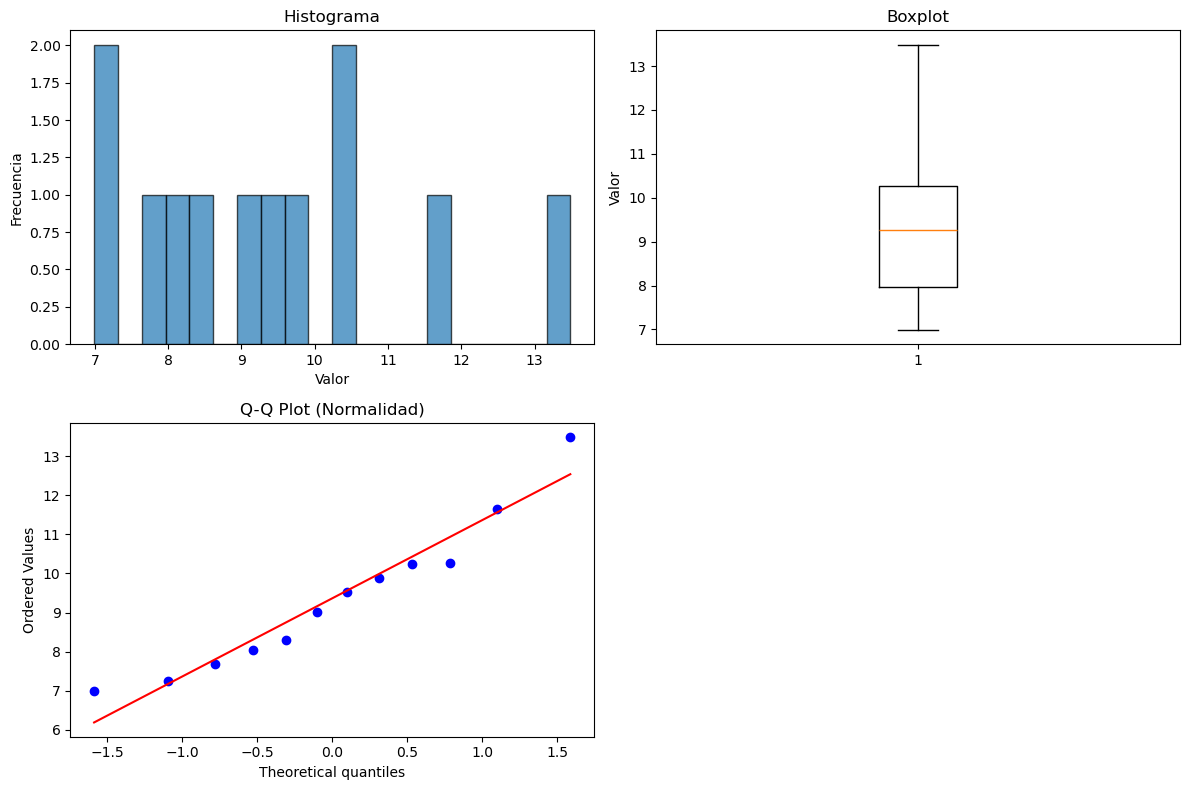

🔬 PRUEBA T PARA UNA MUESTRA
📈 Estadísticas descriptivas (Muestra):
   n = 12
   Media = 9.3647
   Desv. Estándar = 1.9090
   Mediana = 9.2676
   Rango = [6.9892, 13.4876]
📊 Prueba de normalidad (Muestra):
   Shapiro-Wilk: estadístico=0.9413, p-valor=0.5154
   ✅ Normal (α=0.05)
📋 RESULTADOS DE LA PRUEBA
Estadístico t: -1.1528
Grados de libertad: 11.0
p-valor: 0.273435
Nivel de significancia: 0.05
IC 95% para la media: [8.1518, 10.5776]

🎯 INTERPRETACIÓN:
❌ Resultado NO significativo (p ≥ 0.05)
   No se puede rechazar la hipótesis nula


In [6]:
resultado = analizar_desde_archivo('upload')

🎯 CARGA Y VALIDACIÓN DE ARCHIVO
✅ Archivo Excel cargado desde ruta local
✅ Archivo cargado exitosamente

👀 Vista previa de los datos:
          X1         X2
0   5.715559  12.979093
1  10.454580  10.491456
2  10.122547  10.492017
3  12.622800   9.895047
4  12.036413  12.306491
🔍 VALIDACIÓN DE DATOS
📊 Dimensiones: 12 filas × 2 columnas
📝 Columnas: X1, X2
🔢 Columnas numéricas: 2
📝 Columnas no numéricas: 0

📋 RESUMEN:
   ✅ Columnas numéricas listas: 2
   ⚠️  Problemas encontrados: 0
   💡 Recomendaciones: 0
✅ No se encontraron problemas significativos en los datos

🧮 ANÁLISIS AUTOMÁTICO DE PRUEBAS T
Datos cargados: 12 filas × 2 columnas
📊 Detectadas: DOS variables
   Tamaños detectados: X1 = 12, X2 = 12


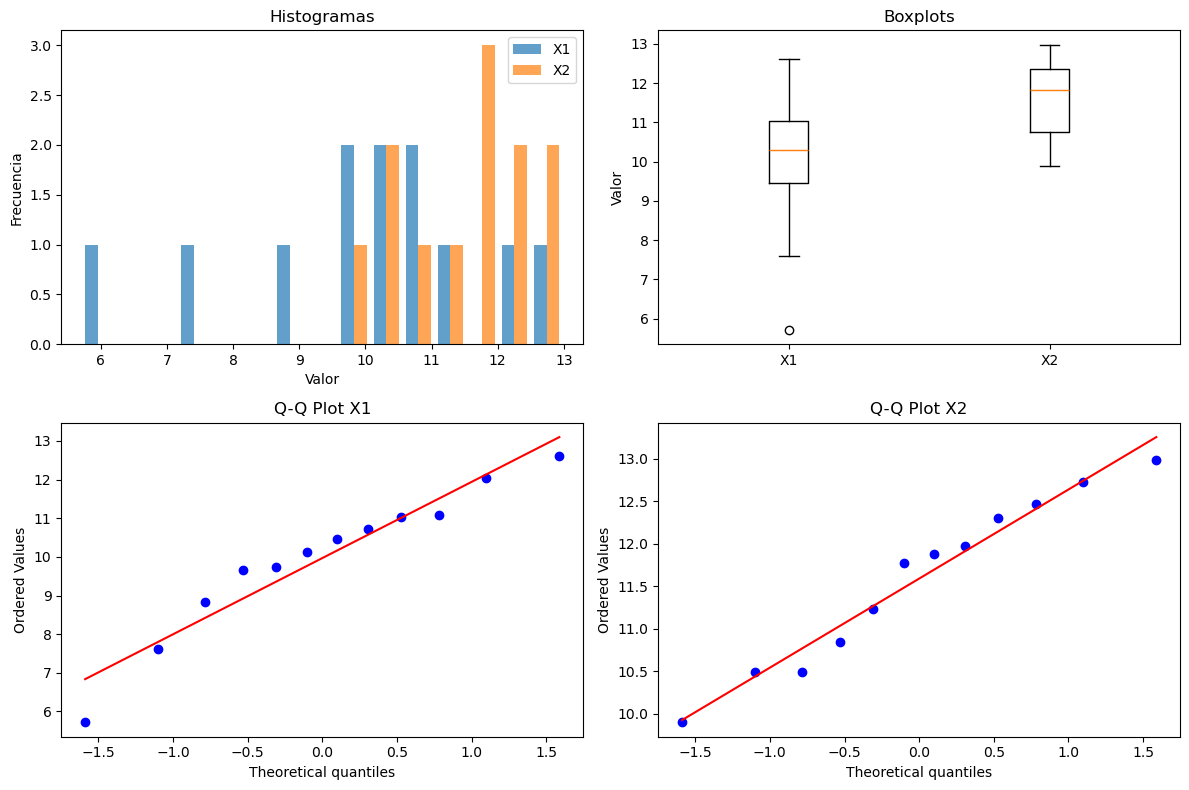

🔬 PRUEBA T PARA MUESTRAS PAREADAS
📈 Estadísticas descriptivas (Grupo 1 (Antes)):
   n = 12
   Media = 9.9684
   Desv. Estándar = 1.8975
   Mediana = 10.2886
   Rango = [5.7156, 12.6228]

📈 Estadísticas descriptivas (Grupo 2 (Después)):
   n = 12
   Media = 11.5878
   Desv. Estándar = 0.9877
   Mediana = 11.8238
   Rango = [9.8950, 12.9791]

📈 Estadísticas descriptivas (Diferencias):
   n = 12
   Media = -1.6194
   Desv. Estándar = 2.4941
   Mediana = -1.2971
   Rango = [-7.2635, 2.7278]

📊 Prueba de normalidad (Diferencias):
   Shapiro-Wilk: estadístico=0.9372, p-valor=0.4623
   ✅ Normal (α=0.05)

📋 RESULTADOS DE LA PRUEBA
Estadístico t: -2.2492
Grados de libertad: 11.0
p-valor: 0.045958
Nivel de significancia: 0.05
IC 95% para la diferencia: [-3.2041, -0.0347]

🎯 INTERPRETACIÓN:
✅ Resultado SIGNIFICATIVO (p < 0.05)
   Se rechaza la hipótesis nula


In [10]:
resultado = analizar_desde_archivo('upload')